# Music Genre Classification

* See README.md for necessary conda setup and the MAESTRO dataset download
* Sections of this code (denoted by the large font markdown titles) can be run independently of eachother, given that the user has the necessary lzma files in the utils directory. Each section begins with the necessary imports and constants.

## Split MAESTRO wavs into 3 minute clips and label with genre
The MAESTRO dataset contains wav files of varying lengths (up to ~40 minutes!) of classical recordings. Basic Pitch cannot make midi predictions on audio that surpasses around 9 minutes. We split the MAESTRO recordings into 3 minute chunks of wav audio.

Imports/constants

In [1]:
import pandas as pd
import math
import re
import os
import librosa
import pickle, lzma
import joblib
from pydub import AudioSegment

MAESTRO_CSV = "../data/classical_dataset.csv"
RAW_AUDIO_FOLDER = "../data/maestro-v3.0.0/"
PROCESSED_AUDIO_FOLDER = "../data/maestro_clips/"
UTIL_FOLDER = "../utils/"

c:\Users\jkamp\miniconda3\envs\mus2vid\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Create a list of audio filepaths

In [2]:
classical_data = pd.read_csv(MAESTRO_CSV)

wavs = list(classical_data['audio_filename'])
for i in range(0, len(wavs)):
    wavs[i] = RAW_AUDIO_FOLDER + wavs[i]

print(wavs)
print(len(wavs))

['../data/maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav', '../data/maestro-v3.0.0/2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.wav', '../data/maestro-v3.0.0/2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.wav', '../data/maestro-v3.0.0/2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01_wav.wav', '../data/maestro-v3.0.0/2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_04_Track04_wav.wav', '../data/maestro-v3.0.0/2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_04_WAV.wav', '../data/maestro-v3.0.0/2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_07_WAV.wav', '../data/maestro-v3.0.0/2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--3.wav', '../data/maestro-v3.0.0/2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_04_WAV.wav', '../data/maestro-v3.0.0/2009/MIDI-Unproc

Split audio into chunks
* Audio splitting class adapted from https://stackoverflow.com/questions/37999150/how-to-split-a-wav-file-into-multiple-wav-files

In [4]:
class SplitWavAudio():
    def __init__(self, folder, filename, path):
        self.folder = folder
        self.filename = filename
        self.filepath = path
        
        self.audio = AudioSegment.from_file(self.filepath, format="wav")

    
    def get_duration(self):
        """Measures duration of a SplitWavAudio audio attribute

        Returns
        -------
         int
           duration of audio in seconds
        """
        return self.audio.duration_seconds
    
    def single_split(self, from_min, to_min, split_filename):
        """Exports a clip of audio from a SplitWavAudio object to a designated file

        Parameters
        ----------
        from_min: int
            time at beginning of audio clip
        to_min: int
            time at end of audio clip
        split_filename: string
            name of audio file to export to
        """
        t1 = from_min * 60 * 1000
        t2 = to_min * 60 * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(self.folder + '\\' + split_filename, format="wav")
        
    def multiple_split(self, min_per_split):
        """Splits a SplitWavAudio object into segments of equal length and exports them to a folder.
        The last segment of audio will be shorter than the desired length because it will stop when the song ends.

        Parameters
        ----------
        min_per_split: int
            length of audio clip in minutes
        """
        total_mins = math.ceil(self.get_duration() / 60)
        for i in range(0, total_mins, min_per_split):
            split_fn = str(int(i/min_per_split)) + '_' + self.filename # Filenames will be the number of the split, then the audio filename. ex: the second 3 minute clip of "audio.wav" is "2_audio.wav"
            self.single_split(i, i+min_per_split, split_fn)
            print(str(split_fn) + ' Done')
            if i == total_mins - min_per_split:
                print('All split successfully')

if not os.path.exists(PROCESSED_AUDIO_FOLDER): os.mkdir(PROCESSED_AUDIO_FOLDER)
counter = 0
for fp in wavs:
    print ("current file: ", counter, "/", len(wavs))
    counter += 1
    new_name = fp
    new_name = re.sub(f"{RAW_AUDIO_FOLDER}[0-9]+/", "", new_name) # resultant directory won't have the year folders present in maestro
    split_wav = SplitWavAudio(PROCESSED_AUDIO_FOLDER, new_name, fp)
    split_wav.multiple_split(min_per_split=3)

current file:  0 / 1276
0_MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav Done
1_MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav Done
2_MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav Done
3_MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav Done
All split successfully
current file:  1 / 1276
0_MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.wav Done
1_MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.wav Done
2_MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.wav Done
3_MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.wav Done
4_MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.wav Done
current file:  2 / 1276
0_MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.wav Done
1_MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.wav Done
2_MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_w

List wav filenames without year folders and generate list of genre labels

In [11]:
classical_data = pd.read_csv(MAESTRO_CSV)

wavs = list(classical_data['audio_filename'])
genres = list(classical_data['Genre'])
for i in range(0, len(wavs)):
    wavs[i] = re.sub("[0-9]+/", "", wavs[i]) # Remove the year folders because the clips created above are all in one folder

genre_list = [] # List of classifications (strings)
for i in genres:
    if not i in genre_list:
        genre_list.append(i)

genre_ints = [] # Classifications (as ints) of each maestro file
for i in range(len(genres)):
    j = 0
    while (not(genres[i] == genre_list[j])):
        j += 1
    genre_ints.append(j)

if (not(os.path.exists(f"{UTIL_FOLDER}genre_list.jb"))):
    joblib.dump(genre_list, f"{UTIL_FOLDER}genre_list.jb")

print(wavs)
print(genre_ints)

['MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.wav', 'MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.wav', 'MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.wav', 'MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01_wav.wav', 'MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_04_Track04_wav.wav', 'MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_04_WAV.wav', 'MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_07_WAV.wav', 'ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--3.wav', 'MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_04_WAV.wav', 'MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV.wav', 'MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_09_Track09_wav.wav', 'MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_04_Track04_wav.wav', 'ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_11_R3_2013_wav--3

Match clips to genre labels

In [12]:
def get_len(wav):
    """Measures the duration of a wav file

    Parameters
    ----------
    wav: string
        audio filepath

    Returns
    -------
    length: int
        duration of audio file
    """
    length = librosa.get_duration(path=(PROCESSED_AUDIO_FOLDER + wav))
    return length

audio_clips = os.listdir(PROCESSED_AUDIO_FOLDER) # list of filepaths in the folder of 3 minute clips we just created
clip_genres = [] # list of corresponding genres to each audio file

for clip in audio_clips:
    match_str = re.sub("^[0-9]+_", "", clip) # remove the clip number to match short clips to their corresponding full songs, which have labels
    wav_index = wavs.index(match_str) # index (in wav array) of the full song
    clip_genres.append(genre_ints[wav_index]) # access tje genre of the full song and assign it to the clip

# remove tracks less than 1 minute seconds long
for i in range(len(audio_clips)):
    print(str(i) + "/" + str(len(audio_clips)))
    if (get_len(audio_clips[i]) < 60):
        print("short")
        audio_clips.pop(i)
        clip_genres.pop(i)
    if (i == len(audio_clips) - 1): # len(audio_clips) changes as short tracks are removed. This avoids going out of the bounds of the list
        break

# print(audio_clips[:10])
# print(clip_genres[:10])

# Save list using pickle for easier access later
with lzma.open(f"{UTIL_FOLDER}audio_clips.xz", "wb") as f:
    pickle.dump(audio_clips, f)
with lzma.open(f"{UTIL_FOLDER}clip_genres.xz", "wb") as f:
    pickle.dump(clip_genres, f)

0/4598
1/4598
2/4598
3/4598
4/4598
5/4598
6/4598
7/4598
8/4598
9/4598
10/4598
11/4598
12/4598
13/4598
14/4598
15/4598
16/4598
17/4598
18/4598
19/4598
20/4598
21/4598
22/4598
23/4598
24/4598
25/4598
26/4598
27/4598
28/4598
29/4598
30/4598
31/4598
32/4598
33/4598
34/4598
35/4598
36/4598
37/4598
38/4598
39/4598
40/4598
41/4598
42/4598
43/4598
44/4598
45/4598
46/4598
47/4598
48/4598
49/4598
50/4598
51/4598
52/4598
53/4598
54/4598
55/4598
56/4598
57/4598
58/4598
59/4598
60/4598
61/4598
62/4598
63/4598
64/4598
65/4598
66/4598
67/4598
68/4598
69/4598
70/4598
71/4598
72/4598
73/4598
74/4598
75/4598
76/4598
77/4598
78/4598
79/4598
80/4598
81/4598
82/4598
83/4598
84/4598
85/4598
86/4598
87/4598
88/4598
89/4598
90/4598
91/4598
92/4598
93/4598
94/4598
95/4598
96/4598
97/4598
98/4598
99/4598
100/4598
101/4598
102/4598
103/4598
104/4598
105/4598
106/4598
107/4598
108/4598
109/4598
110/4598
111/4598
112/4598
113/4598
114/4598
115/4598
116/4598
117/4598
118/4598
119/4598
120/4598
121/4598
122/4598
123

## Extract audio features

Extract openSMILE features

Imports

In [13]:
import opensmile
import numpy as np
import pandas as pd
import pickle, lzma

PROCESSED_AUDIO_FOLDER = "../data/maestro_clips/"
UTIL_FOLDER = "../utils/"

Extract features

In [14]:
def get_smile_feats(audio):
    """Create a feature matrix of openSMILE features from the emobase set (988 total features) for all of the audio clips

    Parameters
    ----------
    audio: list
        filepaths to audio clips

    Returns
    -------
    feature_array: np.array
        array of features for each audio clip. 988 columns for each of 988 features. len(audio) rows (one row for every audio clip).
    """
    # create smile object for feature extraction
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.emobase,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    all_smiles = [] # list of smile features for each clip
    iters = 0
    for file in audio:
        iters += 1
        print(str(iters) + "/" + str(len(audio)))
        
        # get smile features
        smile_feats = smile.process_file(PROCESSED_AUDIO_FOLDER + file)
        # convert from df to list
        smile_feats = smile_feats.values.tolist()
        # convert from 2d list to 1d list
        smile_feats = sum(smile_feats, [])
        all_smiles.append(smile_feats)

    feature_array = np.asarray(all_smiles)
    
    return feature_array

if (not('audio_clips' in locals())): # load from pickle file if needed
    with lzma.open(f"{UTIL_FOLDER}audio_clips.xz", "rb") as f:
        audio_clips = pickle.load(f)

smile_features = get_smile_feats(audio_clips)

with lzma.open(f"{UTIL_FOLDER}smile_features.xz", "wb") as f:
    pickle.dump(smile_features, f)


1/4265
2/4265
3/4265
4/4265
5/4265
6/4265
7/4265
8/4265
9/4265
10/4265
11/4265
12/4265
13/4265
14/4265
15/4265
16/4265
17/4265
18/4265
19/4265
20/4265
21/4265
22/4265
23/4265
24/4265
25/4265
26/4265
27/4265
28/4265
29/4265
30/4265
31/4265
32/4265
33/4265
34/4265
35/4265
36/4265
37/4265
38/4265
39/4265
40/4265
41/4265
42/4265
43/4265
44/4265
45/4265
46/4265
47/4265
48/4265
49/4265
50/4265
51/4265
52/4265
53/4265
54/4265
55/4265
56/4265
57/4265
58/4265
59/4265
60/4265
61/4265
62/4265
63/4265
64/4265
65/4265
66/4265
67/4265
68/4265
69/4265
70/4265
71/4265
72/4265
73/4265
74/4265
75/4265
76/4265
77/4265
78/4265
79/4265
80/4265
81/4265
82/4265
83/4265
84/4265
85/4265
86/4265
87/4265
88/4265
89/4265
90/4265
91/4265
92/4265
93/4265
94/4265
95/4265
96/4265
97/4265
98/4265
99/4265
100/4265
101/4265
102/4265
103/4265
104/4265
105/4265
106/4265
107/4265
108/4265
109/4265
110/4265
111/4265
112/4265
113/4265
114/4265
115/4265
116/4265
117/4265
118/4265
119/4265
120/4265
121/4265
122/4265
123/4265
1

MIDI features
* raw wav audio is converted to pretty_midi objects using basic pitch, then features are extracted from MIDI data

Imports

In [2]:
import pickle
import lzma
import pretty_midi as pm
import pandas as pd
import numpy as np
import tensorflow as tf
from basic_pitch.inference import predict as bp_predict
from basic_pitch import ICASSP_2022_MODEL_PATH

UTIL_FOLDER = "../utils/"
PROCESSED_AUDIO_FOLDER = "../data/maestro_clips/"
BASIC_PITCH_MODEL = tf.saved_model.load(str(ICASSP_2022_MODEL_PATH))


In [18]:
def predict(filestr):
    """Makes a Basic Pitch prediction with the global parameters above given an input audio file.

    Parameters
    ----------
    filestr: string
        The path to the input audio file.

    Returns
    -------
    midi_data: pm.PrettyMIDI
        PrettyMIDI object containing predicted MIDI notes.
    """
    # Run prediction
    STD_ONSET = 0.3
    STD_FRAME = 0.2
    STD_MIN_NOTE_LEN = 50
    STD_MIN_FREQ = None
    STD_MAX_FREQ = 3000
    
    model_output, midi_data, note_events = bp_predict(
        filestr,
        BASIC_PITCH_MODEL,
        STD_ONSET,
        STD_FRAME,
        STD_MIN_NOTE_LEN,
        STD_MIN_FREQ,
        STD_MAX_FREQ
    ) # midi_data is the PrettyMIDI object corresponding to the prediction
    return midi_data

def get_matched_midi(audio, genres):
    """Creates pretty-midi objects from input .wav files
    Matches each MIDI object with a composition year based on the years list

    Parameters
    ----------
    audio: list
        list of audio filepaths.
    genres : list
        list of genres for each .wav file

    Returns
    -------
    df: pd.DataFrame
        A DataFrame containing the pretty_midi obj and the corresponding genre
    """
    prettys = [] # list of pretty_midi objects

    iters = 0
    for i in range(len(audio)):
        print(str(iters) + "/" + str(len(audio)))
        iters += 1

        midi_obj = predict(PROCESSED_AUDIO_FOLDER + audio[i]) # uses basic pitch to convert wav to MIDI
        prettys.append(midi_obj)

    df = pd.DataFrame({'midi_obj': prettys, 'genre': genres})

    return df

if (not('audio_clips' in locals())): # load from pickle file if needed
    with lzma.open(f"{UTIL_FOLDER}audio_clips.xz", "rb") as f:
        audio_clips = pickle.load(f)

if (not('clip_genres' in locals())): # load from pickle file if needed
    with lzma.open(f"{UTIL_FOLDER}clip_genres.xz", "rb") as f:
        audio_clips = pickle.load(f)

matched_midi_df = get_matched_midi(audio_clips, clip_genres)

# Optionally save the matched_midi_df DataFrame in pickle file    
with lzma.open(f"{UTIL_FOLDER}matched_midi.xz", "wb") as f:
    pickle.dump(matched_midi_df, f)

0/4265
Predicting MIDI for ../data/maestro_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--1.wav...
1/4265
Predicting MIDI for ../data/maestro_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--2.wav...
2/4265
Predicting MIDI for ../data/maestro_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--3.wav...
3/4265
Predicting MIDI for ../data/maestro_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014_wav--5.wav...
4/4265
Predicting MIDI for ../data/maestro_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--1.wav...
5/4265
Predicting MIDI for ../data/maestro_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--2.wav...
6/4265
Predicting MIDI for ../data/maestro_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--4.wav...
7/4265
Predicting MIDI for ../data/maestro_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014_wav--5.wav...
8/4265
Predicting MIDI for ../data/maestro_clips/0_MIDI-

Extract MIDI features

In [8]:
def normalize_features(features):
    """Normalizes the features to the range [-1, 1].

    Parameters
    ----------
    features: list of floats
        The array of features.

    Returns
    -------
    list of floats
        normalized features
    """
    # Normalize each feature based on its specific range
    tempo = (features[0] - 150) / 300
    num_sig_changes = (features[1] - 2) / 10
    resolution = (features[2] - 260) / 400
    time_sig_1 = (features[3] - 3) / 8
    time_sig_2 = (features[4] - 3) / 8
    melody_complexity = (features[5] - 0) / 10
    melody_range = (features[6] - 0) / 80

    # Normalize pitch class histogram
    pitch_class_hist = [((f - 0) / 100) for f in features[7:-1]]

    # Return the normalized feature vector
    return [tempo, num_sig_changes, resolution, time_sig_1, time_sig_2, melody_complexity, melody_range] + pitch_class_hist

def get_features(midi_obj):# , all_chords = generate_chord_list()):
    """Extracts specific features from a PrettyMIDI object given its path using the pretty_midi library.

    Parameters
    ----------
        midi_obj: pm.PrettyMIDI 
            the PrettyMIDI object

    Returns
    -------
        features: list of floats
            The extracted features
    """
    
    # tempo: the estimated tempo of the audio file
    try:
        tempo = midi_obj.estimate_tempo()
    except:
        tempo = 0

    # num_sig_changes: the number of time signature changes in the audio file
    num_sig_changes = len(midi_obj.time_signature_changes)

    # resolution: the time resolution of the audio file (in ticks per beat)
    resolution = midi_obj.resolution


    # Extract time signature information
    ts_changes = midi_obj.time_signature_changes
    ts_1, ts_2 = 4, 4
    if len(ts_changes) > 0:
        ts_1 = ts_changes[0].numerator
        ts_2 = ts_changes[0].denominator
    
    # Extract melody-related features
    # melody: a pitch class histogram of the audio file
    melody = midi_obj.get_pitch_class_histogram()
    # melody_complexity: the number of unique pitch classes in the melody
    melody_complexity = np.sum(melody > 0)
    # melody_range: the range of pitch classes in the melody
    melody_range = np.max(melody) - np.min(melody)
    # OPTIONAL feature melody_contour: the temporal evolution of pitch content in the audio file
    # melody_contour = librosa.feature.tempogram(y=file.fluidsynth(fs=16000), sr=16000, hop_length=512)
    # melody_contour = np.mean(melody_contour, axis=0)
    # chroma: a chroma representation of the audio file
    chroma = midi_obj.get_chroma()
    # pitch_class_hist: the sum of the chroma matrix along the pitch axis
    pitch_class_hist = np.sum(chroma, axis=1)

    # Chord detection functions
    # notes = consolidate_notes(midi_obj)
    # chords = calculate_song_chords(notes, all_chords=all_chords)
    # key = estimate_key(chords)
    # changes = chord_changes(chords, midi_obj)
    # grams = n_grams(chords, 3)

    features = normalize_features([tempo, num_sig_changes, resolution, ts_1,
                            ts_2, melody_complexity, melody_range] + list(pitch_class_hist))
    # features.append(key)
    # features.append(changes)
    # features.append(grams)

    return features

def extract_midi_features(midi_df):
    """Extracts features and labels from MIDI objects listed in the DataFrame and concatenates the
    features with their labels into a matrix.

    Parameters
    ----------
        path_df: pd.DataFrame
            A DataFrame with pretty-midi objects and their composition years.

    Returns
    -------
        all_features: numpy.ndarray 
            A matrix of features along with labels.
    """
    all_features = []  # List to store all extracted features
    iters = 0
    for index, row in midi_df.iterrows():
        print(iters)
        iters += 1

        midi_obj = row['midi_obj']
        obj_features = get_features(midi_obj) #all_chords)
        obj_features.append(row['genre'])
        all_features.append(obj_features)
    # Return the numpy array of all extracted features along with corresponding years
    return np.array(all_features)

if (not('matched_midi_df' in locals())): # load from pickle file if needed
    with lzma.open(f"{UTIL_FOLDER}matched_midi.xz", "rb") as f:
        matched_midi_df = pickle.load(f)

# Call the extract_midi_features function with the appropriate path DataFrame to extract the MIDI 
# file features and obtain the feature-label matrix
midi_features = extract_midi_features(matched_midi_df)
# Print the labeled features
print(midi_features)
print(midi_features.shape)

with lzma.open(f"{UTIL_FOLDER}labeled_midi_features.xz", "wb") as f:
    pickle.dump(midi_features, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Train model

Imports

In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from keras.utils import to_categorical
from sklearn.utils import resample
import joblib
import os
import pickle, lzma
from tensorflow import keras
from keras import metrics
import matplotlib.pyplot as plt

UTIL_FOLDER = "../utils/"
SELECTOR_EXT = ".selector"

genre_list = joblib.load(f"{UTIL_FOLDER}genre_list.jb")

Load feature matrix/combine all features

In [4]:
if (not('midi_features' in locals())):
    with lzma.open(f"{UTIL_FOLDER}labeled_midi_features.xz", "rb") as f:
        midi_features = pickle.load(f)
if (not('smile_features' in locals())):
    with lzma.open(f"{UTIL_FOLDER}smile_features.xz", "rb") as f:
        smile_features = pickle.load(f)

labeled_features = np.concatenate((smile_features, midi_features), axis=1) # smile features don't have genre labels, midis do. This way the last column is genre

Select best features


In [5]:
num_cols = labeled_features.shape[1] - 1
print(num_cols)

X = labeled_features[:, :num_cols] # All columns except labels
Y = labeled_features[:, num_cols] # Only labels

selector = SelectKBest(score_func=f_classif, k=256) # Selects the 256 features with strongest relationships to classification

fit = selector.fit(X, Y)
# print(selector.scores_)

if (not(os.path.exists(f"{UTIL_FOLDER}genre_features{SELECTOR_EXT}"))): # save selector to util folder
    joblib.dump(selector, f"{UTIL_FOLDER}genre_features{SELECTOR_EXT}")

features = selector.transform(X) # Narrows feature matrix
# print(features.shape)

labeled_features = np.column_stack([features, Y]) # Add labels back to feature matrix
# print(labeled_features.shape)

1006


c:\Users\jkamp\miniconda3\envs\mus2vid\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [457 479 991 992] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\jkamp\miniconda3\envs\mus2vid\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Partition dataset into training, validation, and testing

In [6]:
def balance_data(data_array, classes = genre_list):
    """Resamples underrespresented classes in dataset so each class has the same amount of audio clips.
    Avoids the model prediciting the most common class all the time.

    Parameters
    ----------
    data_array: np.array
        Feature matrix to be balanced (with labels)
    genres : list, optional
        list of potential classes, by default genre_list

    Returns
    -------
    balanced_array: np.array
        resampled feature matrix with equal samples in each class
    """

    # Create a list of column titles to seperate features and genres
    name_list = ['data'] * (data_array.shape[1] - 1)
    name_list.append('genre')
    # We need a dataframe to use the sklearn.resample function
    data_df = pd.DataFrame(data_array)
    data_df.columns = name_list
    
    # Count the number of samples in each class
    class_balance = np.zeros(len(classes))
    for index, row in data_df.iterrows():
        class_balance[int(row['genre'])] += 1
    max_samples = int(max(class_balance))

    # resample other genres to have the same number of samples as the most common genre
    df_list = [] # list of dataframes to be resampleds
    for class_num in range(len(classes)):
        df_list.append(data_df[data_df['genre'] == class_num])

    balanced_list = [] # list of resampled dataframes
    for df in df_list:
        if (len(df) != max_samples):
            df = resample(df, random_state=42, n_samples=max_samples, replace=True)
        balanced_list.append(df)

    balanced_df = pd.concat(balanced_list) # Add dataframes vertically
    balanced_array = balanced_df.to_numpy() # Convert back to a np.array
    
    return balanced_array

# Shuffle the features
labeled_features = np.random.permutation(labeled_features)

# Partition the Dataset into 3 Sets: Training, Validation, and Test
num = len(labeled_features)
# Calculate the number of samples for training data (60% of the dataset)
num_training = int(num * 0.6)
# Calculate the number of samples for validation data (20% of the dataset)
num_validation = int(num * 0.8)

# Extract the training data (60% of the labeled features)
training_data = balance_data(labeled_features[:num_training])
# Extract the validation data (20% of the labeled features)
validation_data = balance_data(labeled_features[num_training:num_validation])
# Extract the test data (remaining 20% of the labeled features)
test_data = (labeled_features[num_validation:])

# Separate the features from the labels
num_cols = training_data.shape[1] - 1
# Extract features from the training data
training_features = training_data[:, :num_cols]
# Extract features from the validation data
validation_features = validation_data[:, :num_cols]
# Extract features from the test data
test_features = test_data[:, :num_cols]

# Format the features for this multi-class classification problem
num_classes = len(genre_list)
# Extract years from the training data
training_labels = training_data[:, num_cols].astype(int)
# Extract years from the validation data
validation_labels = validation_data[:, num_cols].astype(int)
# Extract years from the test data
test_labels = test_data[:, num_cols].astype(int)

print(test_labels)  # Print the first 10 test labels
print(to_categorical((test_labels)))  # Print the one-hot encoding of the first 10 test labels

[2 1 1 2 2 2 1 3 2 3 1 2 2 2 1 2 3 1 1 1 2 2 2 3 1 0 2 2 1 1 2 1 2 2 2 0 0
 2 2 2 2 2 1 2 2 1 2 1 3 2 1 1 1 2 2 2 2 2 2 2 1 1 2 2 0 2 1 1 1 1 1 3 1 2
 1 2 2 2 2 1 3 1 1 2 2 2 1 2 1 1 2 1 1 2 2 2 1 0 1 1 1 1 2 2 2 2 2 1 2 1 2
 1 3 1 2 2 2 1 1 1 3 0 3 1 2 2 1 0 2 2 2 3 2 2 1 1 1 2 1 2 2 1 2 2 2 1 1 1
 1 3 2 1 1 1 1 1 2 1 1 2 1 2 2 2 2 3 2 3 1 1 2 2 0 1 2 2 0 3 1 2 2 2 2 2 2
 1 1 1 1 2 1 2 3 2 1 3 1 3 3 2 1 0 1 2 2 2 1 1 2 2 2 2 1 2 2 2 2 0 2 2 2 2
 1 2 1 3 2 2 1 2 1 1 2 2 1 1 1 2 2 1 2 1 1 2 1 1 1 2 3 2 1 2 2 2 1 2 2 3 1
 2 2 1 2 1 2 1 1 2 3 2 2 0 2 1 1 1 1 2 2 3 3 2 2 2 1 2 2 3 2 2 2 2 1 1 1 1
 1 3 2 1 1 2 2 1 2 1 2 1 2 1 2 2 1 2 2 2 0 0 2 2 2 2 2 3 2 1 2 1 0 2 2 2 1
 1 2 0 2 1 1 2 2 2 1 2 2 1 2 3 3 2 1 2 1 2 0 2 1 1 1 3 3 2 2 2 1 1 2 2 2 2
 1 2 1 2 2 2 3 0 1 2 0 1 1 1 2 1 1 2 3 0 2 2 2 2 1 2 2 2 2 3 1 2 2 2 2 3 1
 2 2 3 2 2 2 1 0 1 2 2 3 2 3 1 2 2 1 2 2 2 2 2 1 1 1 1 2 2 2 1 2 2 1 0 1 1
 2 2 1 3 3 2 2 2 2 1 1 1 1 2 1 1 2 2 2 2 2 2 2 2 2 2 2 3 3 1 2 2 1 2 2 2 2
 2 2 2 3 3 2 2 2 1 1 2 2 

256
Epoch 1/50
562/562 - 2s - loss: 3.3276 - accuracy: 0.5053 - val_loss: 1.2633 - val_accuracy: 0.5828 - 2s/epoch - 3ms/step
Epoch 2/50
562/562 - 1s - loss: 1.0653 - accuracy: 0.6027 - val_loss: 1.0282 - val_accuracy: 0.5765 - 771ms/epoch - 1ms/step
Epoch 3/50
562/562 - 1s - loss: 0.8881 - accuracy: 0.6339 - val_loss: 1.0281 - val_accuracy: 0.5743 - 833ms/epoch - 1ms/step
Epoch 4/50
562/562 - 1s - loss: 0.8503 - accuracy: 0.6460 - val_loss: 1.1871 - val_accuracy: 0.5442 - 780ms/epoch - 1ms/step
Epoch 5/50
562/562 - 1s - loss: 0.7991 - accuracy: 0.6610 - val_loss: 1.0573 - val_accuracy: 0.5652 - 830ms/epoch - 1ms/step
Epoch 6/50
562/562 - 1s - loss: 0.7665 - accuracy: 0.6743 - val_loss: 1.1070 - val_accuracy: 0.5975 - 793ms/epoch - 1ms/step
Epoch 7/50
562/562 - 1s - loss: 0.7675 - accuracy: 0.6757 - val_loss: 0.9178 - val_accuracy: 0.6105 - 846ms/epoch - 2ms/step
Epoch 8/50
562/562 - 1s - loss: 0.7243 - accuracy: 0.6903 - val_loss: 1.2233 - val_accuracy: 0.5176 - 809ms/epoch - 1ms/step

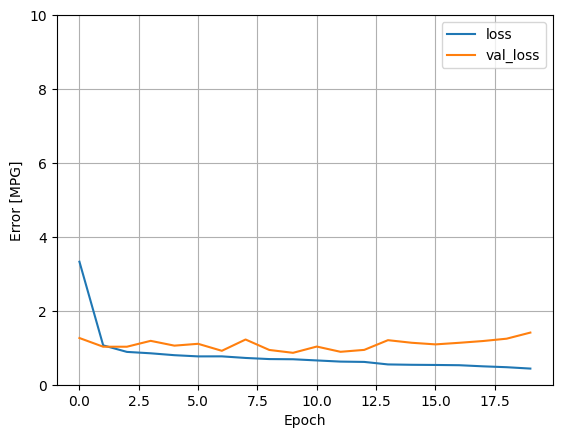

27/27 [==============================] - 0s 750us/step
Total labels in test data:  [41, 301, 436, 75]
Total labels in pred data:  [53, 208, 477, 115]
correct labels in test data:  [12, 134, 323, 55]
prediction probabilities:  [0.22641509433962265, 0.6442307692307693, 0.6771488469601677, 0.4782608695652174]
27/27 [==============================] - 0s 923us/step - loss: 1.0021 - accuracy: 0.6143
Test Loss: 1.0020756721496582
Test Accuracy: 0.6143024563789368


In [7]:
from tensorflow import keras
from keras import metrics
import numpy
import pandas as pd
import matplotlib.pyplot as plt

num_features = training_features.shape[1]
print(num_features)
# Define the model architecture
normalizer = keras.layers.BatchNormalization()
model = keras.Sequential([
    # Input layer with 256 neurons (one for every feature) and ReLU activation
    keras.layers.Dense(num_features, input_shape=(training_features.shape[1],), activation='relu'),
    
    # Hidden layer with 2/3 the neurons (https://shorturl.at/sBLWZ) and ReLU activation
    keras.layers.Dense((num_features * 2/3), activation='relu'),
    
    # Output layer with num_classes neurons and softmax activation for multi-class classification
    keras.layers.Dense(num_classes, activation='softmax')
])

"""
optimizer="adam": The optimizer algorithm to use during training. 
Adam optimizer is chosen, which is a popular optimization algorithm known for its efficiency.

loss='categorical_crossentropy': The loss function used to measure the discrepancy between the 
predicted output and the true output labels. Categorical cross-entropy is suitable for
multi-class classification tasks.

metrics=['accuracy']: The metric(s) to be evaluated during training and testing. 
Accuracy is a commonly used metric to assess the model's performance.
"""

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

"""
training_features, train_labels: Input features and corresponding labels for model training.

validation_features, val_labels: Validation set used to monitor the model's performance 
                                         during training.

batch_size=32: Number of samples per gradient update. Training data is divided into batches, 
               and the model's weights are updated after each batch.

epochs=50: Number of times the model will iterate over the entire training dataset.

callbacks: EarlyStopping to stop training if the validation loss does not improve for a certain 
           number of epochs, and ModelCheckpoint to save the best model based on validation loss.
"""

# Encode the training and validation labels using one-hot encoding
train_labels_encoded = to_categorical(training_labels)
val_labels_encoded = to_categorical(validation_labels)

history = model.fit(x=training_features, y=train_labels_encoded, 
                    validation_data=(validation_features, val_labels_encoded),
                    batch_size=10, epochs=50, verbose=2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                               keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)])

# Plot loss in training and validation data throught epochs of the NN
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)
plt.show()

# Save the entire model to an h5 file
model.save(f"{UTIL_FOLDER}my_model.h5")

# Use the loaded model for prediction
real_labels = [0,0,0,0]
predicted_labels = [0,0,0,0]
correct = [0,0,0,0]

preds = model.predict(test_features)

# Print predictions in test data (optional)
for i in range(len(test_labels)):
    real = test_labels[i]
    prediction = np.argmax(preds[i])
    real_labels[real] += 1
    predicted_labels[prediction] += 1

    # print("Label:      " + str(real))
    # print("Prediction: " + str(prediction))

    if (real == prediction):
        correct[real] += 1

print("Total labels in test data: ", real_labels)
print("Total labels in pred data: ", predicted_labels)
print("correct labels in test data: ", correct)
probabilities = [i / j for i, j in zip(correct, predicted_labels)]
print("prediction probabilities: ", probabilities) # Probability that a class is correcly predicted

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features, to_categorical(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Test on short clips

Imports/constants

In [4]:
import pandas as pd
import re
import numpy as np 
import librosa
import os
import pickle, lzma

SHORT_AUDIO_FOLDER = "../data/wav_clips/"
MAESTRO_CSV = "../data/classical_dataset.csv"

Build testing data

List wav filenames

In [5]:
classical_data = pd.read_csv(MAESTRO_CSV)

wavs = list(classical_data['audio_filename'])
genres = list(classical_data['Genre'])
for i in range(0, len(wavs)):
    wavs[i] = re.sub("[0-9]+/", "", wavs[i]) # Remove the year folders because the clips created above are all in one folder
    wavs[i] = re.sub("_wav", "", wavs[i])

genre_list = [] # List of classifications (strings)
for i in genres:
    if not i in genre_list:
        genre_list.append(i)

genre_ints = [] # Classifications (as ints) of each maestro file
for i in range(len(genres)):
    j = 0
    while (not(genres[i] == genre_list[j])):
        j += 1
    genre_ints.append(j)

print(wavs)
print(genre_ints)

['MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018--1.wav', 'MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008--2.wav', 'MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02--3.wav', 'MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01.wav', 'MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_04_Track04.wav', 'MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_04_WAV.wav', 'MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_07_WAV.wav', 'ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013--3.wav', 'MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_04_WAV.wav', 'MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV.wav', 'MIDI-Unprocessed_15_R1_2011_MID--AUDIO_R1-D6_09_Track09.wav', 'MIDI-Unprocessed_19_R1_2006_01-07_ORIG_MID--AUDIO_19_R1_2006_04_Track04.wav', 'ORIG-MIDI_02_7_10_13_Group_MID--AUDIO_11_R3_2013--3.wav', 'MIDI-Unprocessed_09_R1_2011_

Match wav clips to genres

In [19]:
def get_len(wav):
    """Measures the duration of a wav file

    Parameters
    ----------
    wav: string
        audio filepath

    Returns
    -------
    length: int
        duration of audio file
    """
    length = librosa.get_duration(path=(SHORT_AUDIO_FOLDER + wav))
    return length

audio_clips = os.listdir(SHORT_AUDIO_FOLDER) # list of filepaths in the folder of 15 second clips
audio_clips = audio_clips[:1000]
clip_genres = [] # list of corresponding genres to each audio file
print (audio_clips)

for clip in audio_clips:
    match_str = re.sub("^[0-9]+_", "", clip) # remove the clip number to match short clips to their corresponding full songs, which have labels
    wav_index = wavs.index(match_str) # index (in wav array) of the full song
    clip_genres.append(genre_ints[wav_index]) # access the genre of the full song and assign it to the clip

# remove tracks less than 5 seconds seconds long
for i in range(len(audio_clips)):
    print(str(i) + "/" + str(len(audio_clips)))
    if (get_len(audio_clips[i]) < 5):
        print("short")
        audio_clips.pop(i)
        clip_genres.pop(i)
    if (i == len(audio_clips) - 1): # len(audio_clips) changes as short tracks are removed. This avoids going out of the bounds of the list
        break
# Save list using pickle for easier access later
with lzma.open(f"{UTIL_FOLDER}audio_clips_short.xz", "wb") as f:
    pickle.dump(audio_clips, f)
with lzma.open(f"{UTIL_FOLDER}clip_genres_short.xz", "wb") as f:
    pickle.dump(clip_genres, f)

['0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--1.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--2.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--3.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--5.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--1.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--2.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--4.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--5.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014--2.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014--3.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014--4.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014--5.wav', '0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014--6.wav', '0_MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_01_Track01.wav', '0_MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_02_Track0

NameError: name 're' is not defined

Get features

In [15]:
import numpy as np
import pretty_midi
import tensorflow as tf
import opensmile
import joblib
from basic_pitch.inference import predict as bp
from basic_pitch import ICASSP_2022_MODEL_PATH
BASIC_PITCH_MODEL = tf.saved_model.load(str(ICASSP_2022_MODEL_PATH))

SHORT_AUDIO_FOLDER = "../data/wav_clips/"

In [49]:
def get_features(audio, selector_file = "../utils/genre_features.selector"):
    selector = joblib.load(selector_file)
    midi_obj = bp_predict(audio)

    smile_features = get_smile_features(audio)
    midi_features = get_midi_features(midi_obj)

    audio_features = np.asarray(smile_features + midi_features).reshape((1, len(smile_features + midi_features)))
    audio_features = selector.transform(audio_features)

    return audio_features

def bp_predict(filestr):
    """
    Makes a Basic Pitch prediction with the global parameters above given an input audio file.
    
    Parameters:
        filestr (str): The path to the input audio file.
        
    Returns:
        PrettyMIDI object containing predicted MIDI notes.
    """
    # Run prediction
    STD_ONSET = 0.3
    STD_FRAME = 0.2
    STD_MIN_NOTE_LEN = 50
    STD_MIN_FREQ = None
    STD_MAX_FREQ = 3000
    
    model_output, midi_data, note_events = bp(
        filestr,
        BASIC_PITCH_MODEL,
        STD_ONSET,
        STD_FRAME,
        STD_MIN_NOTE_LEN,
        STD_MIN_FREQ,
        STD_MAX_FREQ
    ) # midi_data is the PrettyMIDI object corresponding to the prediction
    return midi_data

def normalize_features(features):
    """
    Normalizes the features to the range [-1, 1].

    Parameters:
        features (list of float): The array of features.

    Returns:
        list of float: Normalized features.
    """
    # Normalize each feature based on its specific range
    tempo = (features[0] - 150) / 300
    num_sig_changes = (features[1] - 2) / 10
    resolution = (features[2] - 260) / 400
    time_sig_1 = (features[3] - 3) / 8
    time_sig_2 = (features[4] - 3) / 8
    melody_complexity = (features[5] - 0) / 10
    melody_range = (features[6] - 0) / 80

    # Normalize pitch class histogram
    pitch_class_hist = [((f - 0) / 100) for f in features[7:-1]]

    # Return the normalized feature vector
    return [tempo, num_sig_changes, resolution, time_sig_1, time_sig_2, melody_complexity, melody_range] + pitch_class_hist

def get_midi_features(midi_obj):
    """
    Extracts specific features from a PrettyMIDI object given its path using the pretty_midi library.
    Handle any potential errors with MIDI files appropriately.

    Parameters:
        midi_obj: the PrettyMIDI object

    Returns:
        list of float: The extracted features.
    """
        
    # tempo: the estimated tempo of the audio file
    tempo = midi_obj.estimate_tempo()

    # num_sig_changes: the number of time signature changes in the audio file
    num_sig_changes = len(midi_obj.time_signature_changes)

    # resolution: the time resolution of the audio file (in ticks per beat)
    resolution = midi_obj.resolution

    # Extract time signature information
    ts_changes = midi_obj.time_signature_changes
    ts_1, ts_2 = 4, 4
    if len(ts_changes) > 0:
        ts_1 = ts_changes[0].numerator
        ts_2 = ts_changes[0].denominator
    
    # Extract melody-related features
    # melody: a pitch class histogram of the audio file
    melody = midi_obj.get_pitch_class_histogram()
    # melody_complexity: the number of unique pitch classes in the melody
    melody_complexity = np.sum(melody > 0)
    # melody_range: the range of pitch classes in the melody
    melody_range = np.max(melody) - np.min(melody)
    # OPTIONAL feature melody_contour: the temporal evolution of pitch content in the audio file
    # melody_contour = librosa.feature.tempogram(y=file.fluidsynth(fs=16000), sr=16000, hop_length=512)
    # melody_contour = np.mean(melody_contour, axis=0)
    # chroma: a chroma representation of the audio file
    chroma = midi_obj.get_chroma()
    # pitch_class_hist: the sum of the chroma matrix along the pitch axis
    pitch_class_hist = np.sum(chroma, axis=1)
    # Chord detection functions
    # chords = calculate_song_chords(midi_obj)
    # changes = chord_changes(chords, midi_obj)
    # grams = n_grams(chords, 3)

    features = normalize_features([tempo, num_sig_changes, resolution, ts_1,
                            ts_2, melody_complexity, melody_range] + list(pitch_class_hist))
    # features.append(chords)
    # features.append(changes)
    # features.append(grams)

    return features

def get_smile_features(audio):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.emobase,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    # get smile features
    smile_feats = smile.process_file(audio)
    # convert from df to list
    smile_feats = smile_feats.values.tolist()
    # convert from 2d list to 1d list
    smile_feats = sum(smile_feats, [])
    
    return smile_feats

if (not("audio_clips" in locals())):
    with lzma.open(f"{UTIL_FOLDER}audio_clips_short.xz", "rb") as f:
        audio_clips = pickle.load(f)

test_features = get_features(SHORT_AUDIO_FOLDER + audio_clips[0])
counter = 1
for i in range(len(audio_clips)):
    print (str(counter) + "/" + str(len(audio_clips)))
    counter += 1

    features = get_features(SHORT_AUDIO_FOLDER + audio_clips[i+1])
    test_features = np.vstack((test_features, features))

test_features = np.asarray(test_features)

with lzma.open(f"{UTIL_FOLDER}short_audio_features.xz", "wb") as f:
    pickle.dump(test_features, f)


Predicting MIDI for ../data/wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--1.wav...
1/1000
Predicting MIDI for ../data/wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--2.wav...
2/1000
Predicting MIDI for ../data/wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--3.wav...
3/1000
Predicting MIDI for ../data/wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_01_R1_2014--5.wav...
4/1000
Predicting MIDI for ../data/wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--1.wav...
5/1000
Predicting MIDI for ../data/wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--2.wav...
6/1000
Predicting MIDI for ../data/wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--4.wav...
7/1000
Predicting MIDI for ../data/wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_02_R1_2014--5.wav...
8/1000
Predicting MIDI for ../data/wav_clips/0_MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014--2.wav...
9/1000
Predicting

IndexError: list index out of range

# Test model on clips

In [1]:
import tensorflow as tf
import lzma, pickle
from keras.utils import to_categorical
UTIL_FOLDER = "../utils/"

model = tf.keras.models.load_model(f'{UTIL_FOLDER}my_model.h5')

with lzma.open(f"{UTIL_FOLDER}clip_genres_short.xz", "rb") as f:
    test_labels = pickle.load(f)
# with lzma.open(f"{UTIL_FOLDER}short_audio_features.xz", "rb") as f:
#     test_features = pickle.load(f)

In [2]:
with lzma.open(f"{UTIL_FOLDER}short_audio_features.xz", "rb") as f:
    test_features = pickle.load(f)

print(test_features.shape)

(1000, 256)


In [3]:
test_loss, test_accuracy = model.evaluate(test_features, to_categorical(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

32/32 [==============================] - 0s 2ms/step - loss: 1.9372 - accuracy: 0.4980
Test Loss: 1.937165379524231
Test Accuracy: 0.49799999594688416
